# ISLR- Python Ch6 -- Lab 1: Subset Selection Methods 

- [Load Dataset](#Load-Dataset)
- [6.5.1 Perform Best Subset Selection](#6.5.1-Perform-Best-Subset-Selection)
- [6.5.2 Forward and Backward Stepwise Selection](#6.5.2-Forward-and-Backward-Stepwise-Selection)
- [6.5.3 Validation and Cross Validation Model Selection](#6.5.3-Validation-and-Cross-Validation-Model-Selection)

In [1]:
# perform standard imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy

from tqdm import tqdm
from operator import itemgetter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Dataset

The 'Hitters' dataset contains statistics for baseball players and their salaries. Some of the rows have missing data we need to locate these rows and drop them from the dataframe.

In [2]:
# Load the Hitters dataset. Pandas offers great flexibillity with dealing with missing values as keywords to 
# pd.read but lets read in all values so we can see how many we are missing.
hitters = pd.read_csv('../../data/Hitters.csv',index_col=0)

# Get the number of players  and the number of players with missing values
print('Hitters contains', len(hitters), 'players.')
num_missing = np.sum(hitters.isnull().any(axis=1))
print('We are missing data for', num_missing, 'players.')

# now remove the missing players for dataframe
hitters = hitters.dropna()
print('After removal Hitters contains', len(hitters), 'players.')
print('Shape=', hitters.shape)
hitters.head()

Hitters contains 322 players.
We are missing data for 59 players.
After removal Hitters contains 263 players.
Shape= (263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Notice that columns League, Division and NewLeague are categorical. We will need to make dummy variables for these.

In [3]:
# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.head(2)

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
-Alan Ashby,0,1,0,1,0,1
-Alvin Davis,1,0,0,1,1,0


In [4]:
# Generate new dataframe with new dummy variables
df = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)
# add new dummy variables
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)
df.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480,0,1,0


## 6.5.1 Perform Best Subset Selection

Best subset selection forms every possible model from the predictors. It then compares models with the same nuber of predictors using RSS or R^2. Once the best model is picked for a given number of predictors, Models with different numbers of predictors are compared using one of the information criteria (AIC, BIC, Adj R^2), or by Cross-validation to select from among the models the model with the lowest TEST MSE.

In general, this method is not used because the computational cost is high. For a model with p-predictors, we must consider 2^p models. As such there is not a 'built-in' sklearn module for doing this. We will write a few helper functions to accomplish model selection.

In [11]:
def best_subsets(dataframe, predictors, response, max_features=8):
    """
    Regresses response onto subsets of the predictors in dataframe. Compares models with equal feature 
    numbers choosing the one with the lowest RSS as the 'best' model for that number of features.
    
    PARAMETERS
    ----------
    dataframe : pandas dataframe obj containing responses and predictors
    predictors : list of column names of dataframe used as features
    response : list of column name of dataframe used as target
    
    RETURNS
    -------
    a list of best models, one per feature number
    
    ex.
    [best 1 feat model, best two feat model] = best_subsets(df, predictors, response, max_features = 2)
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(dataframe[features])
        y = dataframe[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def get_best_kth_model(k):
        """
        Returns the model from all models with k-predictors with the lowest RSS.
        """
        results = []

        for combo in combinations(predictors, k):
            # process linear model with this combo of features
            results.append(process_linear_model(list(combo)))

        # sort the models and return the one with the smallest RSS
        return sorted(results, key= itemgetter(1)).pop(0)[0]
    
    models =[]
    for k in tqdm(range(1,max_features+1)):
        models.append(get_best_kth_model(k))
    
    return models

In [64]:
# call our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

100%|██████████| 19/19 [21:00<00:00, 66.36s/it]


In [65]:
# The best two variable model has CRBI and Hits as predictors
models[1].params

const   -47.955902
Hits      3.300845
CRBI      0.689899
dtype: float64

### Plot Best Models for Each Predictor Number

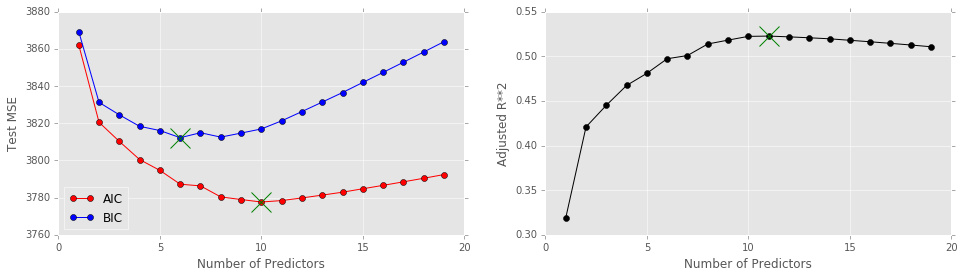

In [75]:
# Now that we have the best models for a given number of varaibles we can compare models with different
# predictors using aic, bic and r_adj. Note AIC and Mallow's Cp are proportional to each other. We will 
# create plots of these statistics to find the best model for baseball player salary.
aics = [models[x].aic for x in range(len(models))]
bics = [models[x].bic for x in range(len(models))]
r_adj = [models[x].rsquared_adj for x in range(len(models))]

# find the mins/maxes
min_aic_index, min_aic = min(enumerate(aics), key=itemgetter(1))
min_bic_index, min_bic = min(enumerate(bics), key=itemgetter(1))
max_radj_index, max_radj = max(enumerate(r_adj), key=itemgetter(1))

num_predictors = np.linspace(1,len(models),len(models))
# Create a plot
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
# Add test MSE estimates
ax1.plot(num_predictors, aics, 'r', marker='o', label='AIC');
ax1.plot(num_predictors, bics, 'b', marker='o', label='BIC')

# add the minimums to the axis
ax1.plot(min_aic_index+1, min_aic, 'gx', markersize=20, markeredgewidth=1)
ax1.plot(min_bic_index+1, min_bic, 'gx', markersize=20, markeredgewidth=1)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Test MSE');
ax1.legend(loc='best');

# Add Adj R**2
ax2.plot(num_predictors, r_adj,'k', marker='o')
ax2.plot(max_radj_index+1, max_radj, 'gx', markersize=20, markeredgewidth=1)
ax2.set_xlabel('Number of Predictors');
ax2.set_ylabel('Adjusted R**2');

So all the estimates of the test error indicate we need a model with more than 5 predictors. The AIC and Adj $R^2$ indicate 10-11 predictors and the BIC statistic indcates 6 predictors.

In [78]:
# The Lowest BIC model has the following coeffecients
models[5].params

const          91.511798
AtBat          -1.868589
Hits            7.604398
Walks           3.697647
CRBI            0.643017
PutOuts         0.264308
Division_W   -122.951534
dtype: float64

## 6.5.2 Forward and Backward Stepwise Selection

As with Best-Subset Selection, we will need to custom write methods for performing Forward and Backward Stepwise selection. In sklearn there is a method called recusrsive feature elimination similar to Backward Stepwise Selection, but no methods I can find for Forward Selection.

The Forward Stepwise Selection algortihm sequentially adds predictors to the null model selecting the predictors that result in the lowest RSS for each added predictor. It then compares models with different features using Information Criteria or Cross-Validatation.

In [9]:
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [12]:
# Call our forward step function
# set up inputs
predictors = list(df.columns)
predictors.remove('Salary')
# call forward_step_select
mods = forward_step_select(df,predictors,['Salary'],max_features=19)

In [13]:
mods[6][1].params # The seventh models features agree with regsubsets fwd result from lab.

const         109.787306
CRBI            0.853762
Hits            7.449877
PutOuts         0.253340
Division_W   -127.122393
AtBat          -1.958885
Walks           4.913140
CWalks         -0.305307
dtype: float64

Backwards subset selection (not implemented here) works very similary to forward except we remove features in the update_model function based on the feature which reduces the RSS the most. In the TEST MSE plot above we are moving from right to left reducing the number of predictors until we reach a minimum in the AIC or BIC curve.

## 6.5.3 Validation and Cross Validation Model Selection

### Validation: Train/Test Split

We start by splitting the data into a train set and a test set to perform validation.

In [38]:
# create an index to break the hitters dataframe into a train and test set that are roughly equal in size
np.random.seed(0)
index = np.random.choice([True, False], size=len(df))

# split the data into train and validation sets
df_train = df[index]
df_test = df[~index]

### Construct models from the Train Set

In [39]:
# Now we construct models from the training set selecting the best models using our best_subsets function
predictors = list(df_train.columns)
predictors.remove('Salary')
models = best_subsets(df_train, predictors, ['Salary'], max_features=19)

100%|██████████| 19/19 [18:28<00:00, 58.35s/it]


### Evaluate MSE of Models on Validation Set

In [62]:
# now for each of the models we will perform prediction and get MSE on the test data
mses = np.array([])
for model in models:
    # get the predictors for this model, ignore constant
    features = list(model.params.index[1:])
    
    # get the corresponding columns of df_test
    X_test = sm.add_constant(df_test[features])
    
    # make prediction for this model
    salary_pred = model.predict(X_test)
    
    # get the MSE for this model
    mses = np.append(mses, np.mean((salary_pred - df_test.Salary.values)**2))
print('MSEs =', mses)

MSEs = [ 197453.6869  174455.6938  171032.0227  157148.6279  160632.673
  157574.844   163299.0029  159484.9149  163055.7555  162809.7743
  156822.2382  160005.0154  159949.2195  156373.8562  157087.9244
  158351.0176  158340.0544  157564.9262  156763.4384]


### Determine the Best Model (lowest Test MSE)

In [47]:
min_index, min_mse = min(enumerate(mses), key=itemgetter(1))
print(min_index, min_mse)

13 156373.856185


Note this result is different from the lab. Here we have found the lowest MSE for a 14 variable model. The difference is likely due to a different split of the data into train and validation sets.

In [53]:
# The best 10 variable model (as in the text) is
print('10 Variable Model:', list(models[9].params.index))

10 Variable Model: ['const', 'AtBat', 'Hits', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts', 'Errors', 'League_N', 'NewLeague_N']


In [54]:
# The model we found here was 14 variables
print('14-Variable Model:', list(models[12].params.index))

14-Variable Model: ['const', 'AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'PutOuts', 'Errors', 'League_N', 'NewLeague_N']


### Plot MSEs 

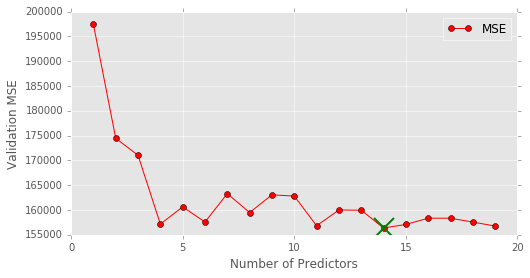

In [61]:
# We can also plot all the models MSEs
# set predictors for x-axis
num_predictors = np.linspace(1,len(models),len(models))

fig, ax1 = plt.subplots(figsize=(8,4));

# add the mse and mimimum mse to the plot
ax1.plot(num_predictors, mses, 'r', marker='o', label='MSE')
ax1.plot(min_index+1, min_mse, 'gx', markersize=20, markeredgewidth=2)

# Labels and Legend
ax1.set_xlabel('Number of Predictors');
ax1.set_ylabel('Validation MSE');
ax1.legend(loc='best');

### Get Coeffecients of Best Validation Approach Model

Now that we now the best model involves 14 variables, we will perform the best-subset selection again to get the coeffecients of the 14 variable model. We do this to get more accurate estimates of the coeffecients in the 14 variable model.

In [63]:
# Now we construct models from the FULL DATASET selecting the best models using our best_subsets function
predictors = list(df.columns)
predictors.remove('Salary')
models = best_subsets(df, predictors, ['Salary'], max_features=19)

# Print out the Coeffecients of the 14 predictor model determined as Best by Validation approach above.
print(models[13].params)

100%|██████████| 19/19 [20:56<00:00, 66.15s/it]

const         144.679318
AtBat          -2.088328
Hits            7.643645
HmRun           2.340652
Runs           -2.358048
Walks           6.179471
CAtBat         -0.148807
CRuns           1.593162
CRBI            0.717077
CWalks         -0.856584
PutOuts         0.287618
Assists         0.367731
Errors         -3.127125
League_N       44.235227
Division_W   -112.807991
dtype: float64


Notice that the 14 variable model from the full data set is not the same as the 14 variable model ascertained from the training dataset.

## Cross-Validation Model Selection